In [1]:
import torch
print(torch.__version__)

import math
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from torch.optim import Adam

from ddim import visualize_dataset, visualize_diffusion_step, sample_plot_image
from ddim import UNet
from ddim import loss_function, q_sample, p_sample

device = "cuda" if torch.cuda.is_available() else "cpu"

import warnings
warnings.filterwarnings('ignore')


2.5.1+cu124


## Import & Normalize MNIST

In [2]:
to_tensor = transforms.ToTensor()

normalize_transform = transforms.Compose([
    to_tensor,
    transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:

normalize_transform = transforms.Compose([
    transforms.ToTensor(),                 # Convertit l'image [0,1]
    transforms.Lambda(lambda x: x * 2 - 1) # Convertit [0,1] -> [-1,1]
])


In [4]:
mnist_trainset = datasets.MNIST(root='./data', train= True, download=True, transform=normalize_transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=normalize_transform)

train_size = int(0.8 * len(mnist_trainset))
val_size = len(mnist_trainset) - train_size

mnist_trainset, mnist_valset = random_split(mnist_trainset, [train_size, val_size])

In [7]:
image, label = mnist_trainset[0]
image

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

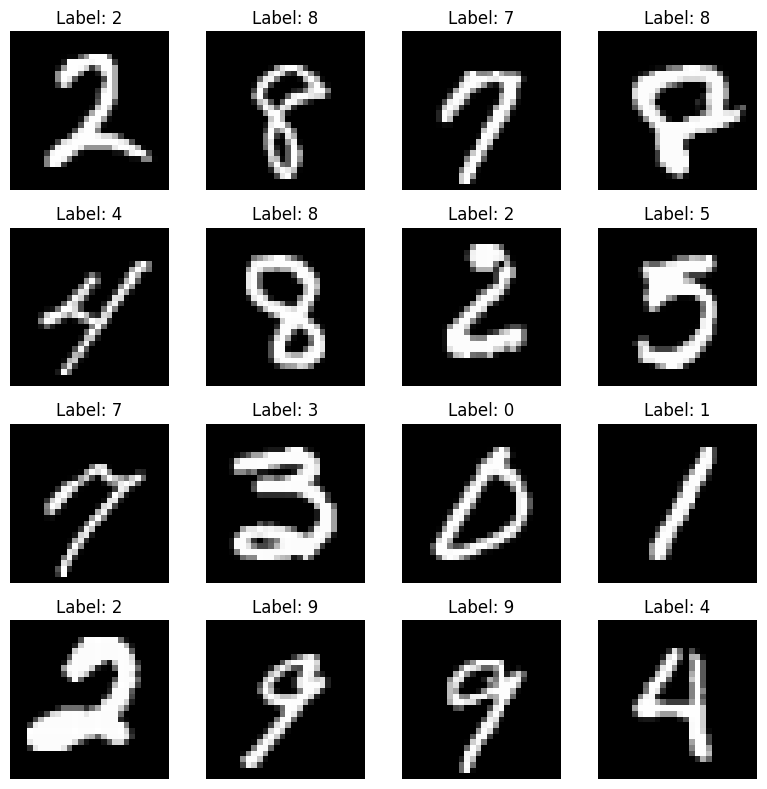

In [5]:
visualize_dataset(mnist_trainset)

# DDIM

In [5]:
T = 1000
BATCH_SIZE = 64
IMG_SIZE = 28

betas = torch.linspace(1e-4, 0.02, T)
alphas = 1. - betas
alphas = torch.cumprod(alphas, dim=0)

eta = 0.5
sigmas = eta * torch.sqrt(1. - alphas).to(device)
num_steps = 10

## Forward Diffusion

In [6]:
train_loader = DataLoader(mnist_trainset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(mnist_valset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=True)

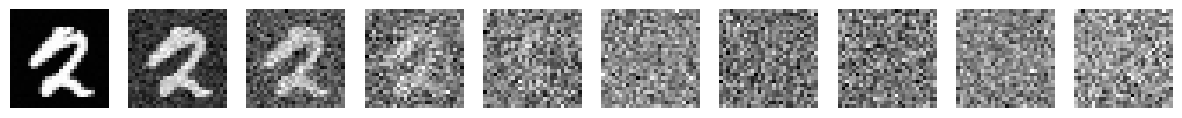

In [7]:
sample_batch, _ = next(iter(train_loader))
sample_image = sample_batch.to(device)
visualize_diffusion_step(sample_batch, alphas, num_steps, BATCH_SIZE)

## Model UNet

### Sinusoidale timestamp Embedding

This part is a classic temporal embedding block which is very widespread and which allows us to add temporal information to our model, which is very important in diffusion models. It is used, for example, by transformers to know the position of a word in a sentence.

### Backward diffusion process with U-Net

For backward diffusion, we'll use a U-Net architecture. The U-Net architecture is an iterative block that follows image downscaling and upscaling, training to learn noise from $x_{t}$ to $x_{t-1}$.

In [8]:
model = UNet()
images = torch.randn(BATCH_SIZE, 1, 28, 28)
timestep = torch.randint(0, T, (BATCH_SIZE,)).long()
output = model(images, timestep)
output.shape

torch.Size([64, 1, 28, 28])

### Training

In [9]:
epoch = 1
model = UNet().to(device)
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

sample_plot_image(IMG_SIZE, T, alphas, sigmas, model, epoch)

In [ ]:
epochs = 100
learning_rate = 1e-3
time_emb_dim = 32

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    step = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} - Training"):
        images, _ = batch
        images = images.to(device)
        
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        #noise = torch.randn_like(images)
        x_t, noise = q_sample(images, t, alphas, BATCH_SIZE)
        noise_pred = model(x_t, t)
        loss = loss_function(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(mnist_trainset)
    if epoch % 2 == 0 :
        print(f"Epoch {epoch + 1}, Average Training Loss: {avg_train_loss:.4f}")
        sample_plot_image(IMG_SIZE, T, alphas, sigmas, model, epoch)

In [10]:
from ddim_v2 import DiffusionTrainer

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

trainer = DiffusionTrainer(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    T=1000,
    alphas=alphas,
    sigmas=sigmas,
    device=device,
    img_size=28,
    sample_interval=2
)

In [ ]:
trainer.train(epochs=10) 

## Backward Diffusion

In [ ]:
@torch.no_grad()
def ddim_sample(x_T, alphas, sigmas, model, T, num_steps=50):
    device = x_T.device
    alphas = alphas.to(device)
    sigmas = sigmas.to(device)

    x_t = x_T
    steps = torch.linspace(T - 1, 0, num_steps, dtype=torch.long).to(device)

    for t in steps:
      t = t.view(-1)  # Transforme en tenseur 1D
      alpha_t = alphas[t]
      eps_theta = model(x_t, t)
      x_t = p_sample(x_t, t, alphas, eps_theta, sigmas)


    return x_t
